<a href="https://colab.research.google.com/github/swiminthewind/colab/blob/main/230926-210802%2B210728%E5%90%8C%E5%B9%B4(%E5%90%84%E8%87%AA%E5%8A%A0band2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks1/")

# 导入库

In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
from osgeo import gdal
import skimage
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras.backend as K

from skimage.transform import resize
from keras import Model
from keras.layers import Input, Conv2D, Conv2DTranspose, Lambda, Dropout, BatchNormalization, Add, Concatenate
from keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from keras.layers import  Activation, Reshape, Dense, Flatten, ZeroPadding2D
from keras.models import save_model, load_model
from keras.initializers import RandomNormal

Instructions for updating:
non-resource variables are not supported in the long term


# 加载影像

In [4]:
def read_tiff(tiff_file):
    data = gdal.Open(tiff_file).ReadAsArray()
    return data

def load_sentinel_data(path):
    img_paths = sorted(glob.glob(path + '*.tif'))
    image = [np.expand_dims(read_tiff(img).astype('float32'), -1) for img in img_paths]
    image = np.concatenate(image, axis=-1)
    print("Image shape: ", image.shape, " Min value: ", image.min(), " Max value: ", image.max())
    return image

In [5]:
S2_img_1 = load_sentinel_data('data/20210802_S2A_10m/')
S2_img_2 = load_sentinel_data('data/20210728_S2A_10m/')
S1_img_1 = load_sentinel_data('data/20210802_S1A_10m_ASCENDING/')
S1_img_2 = load_sentinel_data('data/20210728_S1A_10m_DESCENDING/')
S2_QA_1 = load_sentinel_data('QA/20210802_S2A_QA60/')
S2_QA_2 = load_sentinel_data('QA/20210728_S2A_QA60/')
roi_mask_1 = load_sentinel_data('mask/')

Image shape:  (4193, 6774, 5)  Min value:  nan  Max value:  nan
Image shape:  (4193, 6774, 5)  Min value:  nan  Max value:  nan
Image shape:  (4193, 6774, 2)  Min value:  -49.711483  Max value:  30.08639
Image shape:  (4193, 6774, 2)  Min value:  -51.98666  Max value:  29.782406
Image shape:  (4193, 6774, 1)  Min value:  0.0  Max value:  1024.0
Image shape:  (4193, 6774, 1)  Min value:  0.0  Max value:  2048.0
Image shape:  (4193, 6774, 1)  Min value:  0.0  Max value:  1.0


In [6]:
S2_img = np.concatenate((S2_img_1, S2_img_2), axis=0)
S1_img = np.concatenate((S1_img_1, S1_img_2), axis=0)
S2_QA = np.concatenate((S2_QA_1, S2_QA_2), axis=0)
roi_mask = np.concatenate((roi_mask_1, roi_mask_1), axis=0)
S2_img_3 = np.concatenate((S2_img_2, S2_img_1), axis=0)
S2_img.shape,S1_img.shape,S2_QA.shape,roi_mask.shape

((8386, 6774, 5), (8386, 6774, 2), (8386, 6774, 1), (8386, 6774, 1))

# 切割成256*256

In [7]:
def create_idx_image(rows, cols):
    im_idx = np.arange(rows * cols).reshape(rows, cols)
    return im_idx

def extract_patches(im_idx, patch_size, overlap):
    '''overlap range: 0 - 1 '''
    row_steps, cols_steps = int((1-overlap) * patch_size[0]), int((1-overlap) * patch_size[1])
    patches = skimage.util.view_as_windows(im_idx, patch_size, step=(row_steps, cols_steps))
    return patches

In [8]:
rows, cols = S2_img.shape[:2]

In [9]:
im_idx = create_idx_image(rows, cols)

In [10]:
patches_idx = extract_patches(im_idx, patch_size=(256, 256), overlap=0).reshape(-1, 256, 256)

In [11]:
patches_idx.shape

(832, 256, 256)

# 划分clouds_tiles和no_clouds_tiles

In [12]:
c_dim_QA = S2_QA.shape[-1]

In [13]:
def check_clouds_in_array(arr):
    flat_arr = arr.flatten()
    if 1024 in flat_arr or 2048 in flat_arr:
        return True
    else:
        return False

In [14]:
no_clouds_tiles = []
clouds_tiles = []
for i in range(len(patches_idx)):
    if check_clouds_in_array(S2_QA.reshape(-1, c_dim_QA)[patches_idx[i]]) == False:
        no_clouds_tiles.append(i)
    else:
        clouds_tiles.append(i)

In [15]:
print(clouds_tiles)
print(no_clouds_tiles)
print(len(clouds_tiles))
print(len(no_clouds_tiles))

[26, 27, 52, 53, 58, 78, 79, 80, 104, 105, 106, 130, 131, 137, 156, 157, 158, 182, 183, 209, 286, 287, 312, 313, 338, 339, 340, 341, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 429, 430, 431, 432, 433, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 456, 457, 458, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 508, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 590, 591, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 616, 624, 625, 626, 627, 629, 630, 631, 632, 633, 650, 651, 652, 653, 655, 656, 657, 658, 659, 676, 677, 678, 679, 681, 682, 683, 684, 695, 696, 697, 702, 703, 708, 719, 721, 722, 723, 728, 729, 734, 735, 736, 737, 738, 745, 747, 748, 754, 755, 756, 760, 761, 762, 763, 764, 765, 766, 780, 782, 786, 787, 788, 789, 790, 791, 80

# 划分roi_tiles和no_roi_tiles

In [16]:
c_dim_mask = roi_mask.shape[-1]

In [17]:
def check_bounds_in_array(arr):
    flat_arr = arr.flatten()
    if 1 in flat_arr:
        return True
    else:
        return False

In [18]:
roi_tiles = []
no_roi_tiles = []
for i in range(len(patches_idx)):
    if check_bounds_in_array(roi_mask.reshape(-1, c_dim_mask)[patches_idx[i]]) == True:
        roi_tiles.append(i)
    else:
        no_roi_tiles.append(i)

In [19]:
print(roi_tiles)
print(no_roi_tiles)
print(len(roi_tiles))
print(len(no_roi_tiles))

[9, 10, 11, 12, 13, 14, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 187, 188, 189, 190, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 250, 251, 252, 253, 254, 255, 256, 257, 258, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 4

# Split image into training, validation and testing tiles

In [20]:
def common_elements(a, b):
    set_a = set(a)
    set_b = set(b)
    common_set = set_a.intersection(set_b)
    return list(common_set)

tiles_idx = common_elements(roi_tiles, no_clouds_tiles)
tst_tiles_idx = common_elements(roi_tiles, clouds_tiles)

In [21]:
print(tst_tiles_idx)
print(len(tst_tiles_idx))

[520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 27, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 52, 53, 58, 573, 574, 575, 576, 577, 578, 579, 580, 581, 78, 79, 80, 590, 591, 603, 604, 605, 606, 607, 608, 104, 105, 106, 616, 130, 131, 137, 157, 158, 695, 696, 697, 719, 721, 722, 723, 745, 747, 748, 426, 427, 429, 443, 444, 450, 451, 452, 453, 454, 456, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 508]
105


In [22]:
def define_trn_val_tst_mask(tiles_grid_idx, tiles_idx, tst_tiles_idx, no_roi_tiles, grid_size=(10,10), plot=True):
    num_tiles_rows = grid_size[0]
    num_tiles_cols = grid_size[1]

    tiles_idx = np.random.permutation(tiles_idx)
    trn_tiles_idx = tiles_idx[:int(0.7*len(tiles_idx))]
    val_tiles_idx = tiles_idx[int(0.7*len(tiles_idx)):]

    print(trn_tiles_idx, val_tiles_idx)
    print(len(trn_tiles_idx),len(val_tiles_idx))

    tiles_numbers = np.zeros_like(tiles_grid_idx)
    for i in range(len(tiles_grid_idx)):
        tiles_numbers[i] = i

    mask = np.zeros_like(tiles_grid_idx)
    for idx in val_tiles_idx:
        mask[tiles_numbers==idx] = 1
    for idx in tst_tiles_idx:
        mask[tiles_numbers==idx] = 2
    for idx in no_roi_tiles:
        mask[tiles_numbers==idx] = 3

    mask = mask_tiles(mask.reshape(num_tiles_rows, num_tiles_cols, 256, 256))
    if plot:
        plt.figure(figsize=(5,5))
        plt.imshow(mask, cmap='PuBuGn')
        plt.axis('off')
        plt.show()
        plt.close()
    return mask

def mask_tiles(patches):
    num_blocks_r, num_blocks_c, rows_block, cols_block = patches.shape
    img = np.zeros((num_blocks_r*rows_block, num_blocks_c*cols_block), dtype=patches.dtype)
    for i in range(num_blocks_r):
        for j in range(num_blocks_c):
            img[rows_block*i:(rows_block*i+rows_block), cols_block*j:(cols_block*j+cols_block)] = patches[i,j]
    return img

[115 826 279 363 618 108 582 594 557 196  62 126 149 668 277 179  39  30
 252 562 803 595  28 132 726 485 330 801 568  29  13 532 280 303 166 109
 231 253 779  61 511 584 386 112 332 285 147  36 117 415  11 205 140 226
 509 334 561 121 124 638 224 798 329 227 771 175 356 361  41 163 778 382
 409 152  35  88 304 718 193 144 151 694 670 171 724 110 648 804 113 384
 257 197 692  59  63 170 336 753 125 204  81 799  84 232 829 310 644  57
 612 609 107 639 565 567  40 387 537 822  69 534 805 172  34 159 135 620
 773 673 621 138 164  86 258 380 331 587  14 195 720 169 774  55 201 254
 645 831 139 669 699  67 123 428 560 610 540 174 133 309 167  90 165 307
 559 358 306 188  82 203 145  64 583 611 114 328 142 615 643 750  66 383
 647 586 777 770  65 507 536 413 278 641 173 111  87 122 558 189 385 566
 362 640 619 177 357 674 178 672  92 255  93  37 228 725  54 134 440 276
  96 190 589 727 355 229 538  60 146 693] [308 671 223 802 176 360 198 119 613 698 150  91 585 388 251 148 311 455
 354 614 

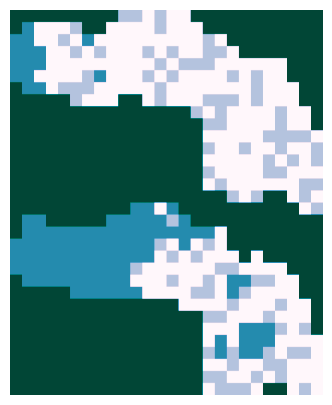

In [23]:
mask_trn_val_tst = define_trn_val_tst_mask(patches_idx, tiles_idx, tst_tiles_idx, no_roi_tiles, (rows//256, cols//256))

# Extract patches from the training and validation

In [24]:
overlap=0
patches_mask = extract_patches(mask_trn_val_tst, patch_size=(256, 256), overlap=overlap).reshape(-1, 256, 256)

In [25]:
idx_trn = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==0))
idx_val = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==256**2))
idx_tst = np.squeeze(np.where(patches_mask.sum(axis=(1, 2))==2*256**2))

patches_idx_trn = patches_idx[idx_trn]
patches_idx_val = patches_idx[idx_val]
patches_idx_tst = patches_idx[idx_tst]

print('Number of training and validation patches: ', len(idx_trn), len(idx_val))

Number of training and validation patches:  226 98


# 影像处理

In [26]:
def db2intensities(img):
    img = 10**(img/10.0)
    return img

def filter_outliers(img, bins=1000000, bth=0.03, uth=0.97, mask=[0]):
    img[np.isnan(img)]=0 # Filter NaN values.
    if len(mask)==1:
        mask = np.zeros((img.shape[:2]), dtype='int64')
    for band in range(img.shape[-1]):
        hist = np.histogram(img[:mask.shape[0], :mask.shape[1]][mask!=2, band].ravel(),bins=bins) # select not testing pixels
        cum_hist = np.cumsum(hist[0])/hist[0].sum()
        max_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<uth])])/100
        min_value = np.ceil(100*hist[1][len(cum_hist[cum_hist<bth])])/100
        img[:,:, band][img[:,:, band]>max_value] = max_value
        img[:,:, band][img[:,:, band]<min_value] = min_value
    return img

def normalize(img):
    '''image shape: [row, cols, channels]'''
    img = 2*(img -img.min(axis=(0,1), keepdims=True))/(img.max(axis=(0,1), keepdims=True) - img.min(axis=(0,1), keepdims=True)) - 1
    return img

In [27]:
S1_img = db2intensities(S1_img)
S1_img.min(), S1_img.max()

(6.3289826e-06, 1020.0909)

In [28]:
S1_img = filter_outliers(S1_img.copy())
S2_img = filter_outliers(S2_img.copy(), bins=int(2**16/2), mask=mask_trn_val_tst)
S2_img_3 = filter_outliers(S2_img_3.copy(), bins=int(2**16/2), mask=mask_trn_val_tst)

In [29]:
S1_img = normalize(S1_img)
S2_img = normalize(S2_img)
S2_img_3 = normalize(S2_img_3)

In [30]:
S1_img = np.concatenate([S1_img,S2_img_3[:,:,:1]],axis=-1)
S1_img.shape

(8386, 6774, 3)

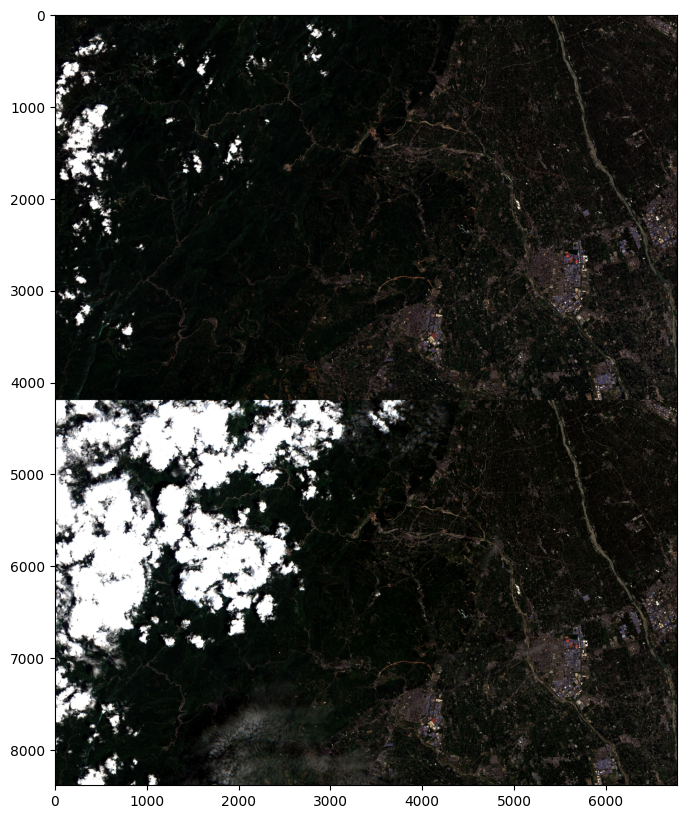

In [31]:
plt.figure(figsize=(10,10))
plt.imshow((S2_img[:,:,[2,1,0]] + 1)/2)
plt.show()
plt.close()

# 影像切片

In [32]:
# c_dim_opt = S2_img.shape[-1]
# S2_img_1 = S2_img.reshape(-1, c_dim_opt)[patches_idx[27]]

In [33]:
# print(S2_img_1.shape)

In [34]:
# plt.figure(figsize=(10,10))
# plt.imshow((S2_img_1[:,:,[2,1,0]] + 1)/2)
# plt.show()
# plt.close()

# cGANs训练

In [35]:
c_dim_sar = S1_img.shape[-1]
c_dim_opt = S2_img.shape[-1]
n_rows = 256
n_cols = 256

## 数据增强
Resize the paches to bigger height and width.

1. Resize the paches to bigger height and width.
2. Randomly crop to the target size.
3. Randomly flip the image horizontally.

In [ ]:
def randomResizeCrop(img_s1, img_s2, load_size=286, fine_size=256, flip=True):

    img_s1 = resize(img_s1, [load_size, load_size], 0)
    img_s2 = resize(img_s2, [load_size, load_size], 0)

    h1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    w1 = int(np.ceil(np.random.uniform(1e-2, load_size-fine_size)))
    img_s1 = img_s1[h1:h1+fine_size, w1:w1+fine_size]
    img_s2 = img_s2[h1:h1+fine_size, w1:w1+fine_size]

    if flip and np.random.random() > 0.5:
        img_s1 = np.fliplr(img_s1)
        img_s2 = np.fliplr(img_s2)

    return img_s1, img_s2

## 构建生成器

In [ ]:
# define an encoder block
def encoder_block(input_data, n_filters, k_size=3, strides=2, activation='relu', padding='same', batchnorm=True, name='None'):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    x = Conv2D(n_filters, k_size, strides=strides, padding=padding, kernel_initializer=init, name=name+'_conv2D')(input_data)
    if batchnorm:
        x = BatchNormalization(momentum=0.8, name=name+'_bn')(x, training=True)
    if activation is 'LReLU':
        x = LeakyReLU(alpha=0.2, name=name+'_act_LReLU')(x)
    else:
        x = Activation('relu', name=name+'_act_relu')(x)
    return x

# define a decoder block
def decoder_block(input_data, n_filters, k_size=3, strides=2, padding='same', name='None'):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    x = Conv2DTranspose(n_filters, k_size, strides=strides, padding=padding, kernel_initializer=init, name=name+'_deconv2D')(input_data)
    x = BatchNormalization(momentum=0.8, name=name+'_bn')(x, training=True)
    x = Activation('relu', name=name+'_act_relu')(x)
    return x

def residual_block(input_x, n_kernels, name='name'):
    x = encoder_block(input_x, n_kernels, strides=1, name=name+'rba')
    x = Dropout(0.5, name=name+'drop')(x, training=True)
    x = encoder_block(x, n_kernels,  strides=1, activation='linear', name=name+'rbb')
    x = Add(name=name+'concatenate')([x, input_x])
    return x

In [ ]:
def build_generator2D(model_shape, filters=64, last_act='tanh', n_residuals=9, summary=False, model_file=None, name='gan_g_'):

    init = RandomNormal(stddev=0.02)
    n_rows = model_shape[0]
    n_cols = model_shape[1]
    in_c_dims = model_shape[2]
    out_c_dims = model_shape[3]

    input_shape = (n_rows, n_cols, in_c_dims)
    input_layer = Input(shape=input_shape, name=name+'_input')

    x = input_layer
    x = encoder_block(x, 1*filters, k_size=7, strides=1, batchnorm=False, name=name+'_e1')
    x = encoder_block(x, 2*filters, name=name+'e2') # rows/2, cols/2
    x = encoder_block(x, 4*filters, name=name+'e3') # rows/4, cols/4

    for i in range(n_residuals):
        x = residual_block(x, n_kernels=4*filters, name=name+str(i+1)+'_')  # rows/4, cols/4

    x = decoder_block(x, 2*filters, name=name+'d1') # rows/2, cols/2
    x = decoder_block(x, 1*filters, name=name+'d2') # rows, cols
    x = Conv2D(out_c_dims, 7, padding='same',  kernel_initializer=init, name=name+'d_out')(x)   # rows, cols

    output = Activation(last_act, name=name+last_act)(x)

    model = Model(inputs=[input_layer], outputs=[output], name='Generator'+name[-3:])
    if (summary):
        model.summary()
    return model

In [ ]:
# Setting the model shape
gen_shape = (n_rows, n_cols, c_dim_sar, c_dim_opt)
generator = build_generator2D(gen_shape, filters=64, name='gen', summary=True)
tf.keras.utils.plot_model(generator, show_shapes=True)

## 构建判别器

In [ ]:
########################  NETWORK ARCHITECTURES  ###############################
def build_discriminator2D(input_shape, filters=64, name='d', summary=False):
    """
    Create a Discriminator Model using hyperparameters values defined as follows
    """
    # weight initialization
    init = RandomNormal(stddev=0.02)

    input_img  = Input(shape=input_shape, name=name+'_input')
    d = input_img
    d = encoder_block(d, 1*filters, k_size=4, activation='LReLU', batchnorm=False, name=name+'_1')
    d = encoder_block(d, 2*filters, k_size=4, activation='LReLU', name=name+'_2')
    d = encoder_block(d, 4*filters, k_size=4, activation='LReLU', name=name+'_3')

    d = ZeroPadding2D()(d)
    d = encoder_block(d, 8*filters, k_size=4, activation='LReLU', strides=1, padding='valid', name=name+'_4')
    d = ZeroPadding2D()(d)
    logits = Conv2D(1, (4,4), padding='valid', kernel_initializer=init, name=name+'_conv2D_5')(d)
    out = Activation('sigmoid', name=name+'_act_sigmoid')(logits)

    model = Model(inputs=[input_img], outputs=[out, logits], name=name)
    if (summary):
        model.summary()
    return model

In [ ]:
dis_shape = (n_rows, n_cols, c_dim_sar + c_dim_opt)
discriminator = build_discriminator2D(dis_shape, filters=64, name='dis', summary=True)
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## 损失函数

In [ ]:
def cross_entropy_loss(labels, logits):
    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    return loss

def lsgan_loss(labels, logits):
        loss = tf.reduce_mean(tf.squared_difference(logits, labels))
        return loss

def l1_loss(a, b):
    loss = tf.reduce_mean(tf.abs(a - b))
    return loss

## 构建计算图

In [ ]:
K.clear_session() # cleaning previous sessions

batch_size = 1
LAMBDA = 100

# BUILDING NETWORKS GRAPHS
Generator = build_generator2D(gen_shape, filters=64, name='gen', summary=False)
Discriminator = build_discriminator2D(dis_shape, filters=64, name='dis', summary=False)

# GRAPH INPUT DATA
REAL_SAR = tf.placeholder(tf.float32,
                        [batch_size, n_rows, n_cols, c_dim_sar],
                        name='real_sar')

REAL_OPT = tf.placeholder(tf.float32,
                        [batch_size, n_rows, n_cols, c_dim_opt],
                        name='real_opt')

FAKE_OPT = Generator(REAL_SAR)

REAL_PAIR = tf.concat([REAL_SAR, REAL_OPT], axis=-1)
FAKE_PAIR = tf.concat([REAL_SAR, FAKE_OPT], axis=-1)

# Discriminator
D_real, D_real_logits = Discriminator(REAL_PAIR)
D_fake, D_fake_logits = Discriminator(FAKE_PAIR)

# Discriminator loss
d_loss_real = cross_entropy_loss(tf.ones_like(D_real), D_real_logits)
d_loss_fake = cross_entropy_loss(tf.zeros_like(D_real), D_fake_logits)
d_loss = (d_loss_real + d_loss_fake) / 2.0

# Reconstruction loss
reco_loss = LAMBDA * l1_loss(REAL_OPT, FAKE_OPT)

# Generator loss
g_loss_ = cross_entropy_loss(tf.ones_like(D_fake), D_fake_logits)
g_loss =  g_loss_ + reco_loss

### 定义优化器

In [ ]:
# Collecting variables for training
t_vars = tf.trainable_variables()
# print(t_vars)

d_vars = [var for var in t_vars if 'dis' in var.name] # Discriminator variables
g_vars = [var for var in t_vars if 'gen' in var.name] # Generator variables

# Optimizer parameters
lr_d = 0.0002
lr_g = 0.0002
beta1 = 0.5

# Assings variables and corresponding lossses to be minimized
d_optim = tf.train.AdamOptimizer(lr_d, beta1=beta1).minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(lr_g, beta1=beta1).minimize(g_loss, var_list=g_vars)

# Build the graph
sess = tf.Session()

# Initialize the all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

### 设置超参数

In [ ]:
epochs = 100
patience = 15 # for early stoppig
num_of_trn_batches = len(patches_idx_trn) // batch_size
num_of_val_batches = len(patches_idx_val) // batch_size
# print(num_of_trn_batches)
# print(num_of_val_batches)

g_steps = 1

saving_path = './'

name = 'sar2opt'

restore = False

In [ ]:
def get_next_batch_generator(patches_idx, s1data, s2data, batch_size=1, shuffle=True, flip=True, train=True):
    num_of_batches = len(patches_idx) // batch_size
    s1data = s1data.reshape(-1, s1data.shape[-1])
    s2data = s2data.reshape(-1, s2data.shape[-1])
    if shuffle:
        np.random.shuffle(patches_idx)
    while True:
        for idx in range(num_of_batches):
            patches_idx_batch = patches_idx[idx*batch_size:(idx+1)*batch_size]
            batch_s1_patches, batch_s2_patches = [], []
            for batch_idx in patches_idx_batch:
                batch_s1, batch_s2 = s1data[batch_idx], s2data[batch_idx]
                if train:
                    # data augmentation
                    batch_s1, batch_s2 = randomResizeCrop(batch_s1, batch_s2, flip=flip)
                batch_s1_patches.append(batch_s1)
                batch_s2_patches.append(batch_s2)

            yield np.array(batch_s1_patches), np.array(batch_s2_patches)

        if shuffle:
            np.random.shuffle(patches_idx)
        idx = 0

def plot_images(sar, real_opt, fake_opt, figsize=(10, 5)):
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(131)
    plt.title('SAR Image')
    ax1.imshow((np.squeeze(sar)[:,:,0]+1)/2., cmap='gray')
    ax1.axis('off')

    ax2 = fig.add_subplot(132)
    plt.title('Target')
    ax2.imshow((np.squeeze(real_opt)[:,:,:3]+1)/2.)
    ax2.axis('off')

    ax2 = fig.add_subplot(133)
    plt.title('Predicted')
    ax2.imshow((np.squeeze(fake_opt)[:,:,:3]+1)/2.)
    ax2.axis('off')

    plt.show()
    # fig.savefig(save_img_path+name+'_img_pt_br_2_elastic_'+str(epoch))
    plt.close()

In [ ]:
get_next_trn_batch = get_next_batch_generator(patches_idx_trn, S1_img, S2_img, flip=True)
get_next_val_batch = get_next_batch_generator(patches_idx_val, S1_img, S2_img, train=False)

## 训练模型

In [ ]:
with tf.Session() as sess:
    sess.run(init_op)

    if restore:
        # Restore variables from disk.
        saver.restore(sess, saving_path+name +".ckpt")
        print("Model restored.")


    best_val_loss = np.inf
    for epoch in range(epochs):
        loss_D, loss_G, loss_l1 = [], [], []

        start_time = time.time()
        for idx in range(0, num_of_trn_batches):

            # selecting a batch of images
            batch_sar, batch_opt = next(get_next_trn_batch)

            feed_dict={REAL_SAR: batch_sar, REAL_OPT: batch_opt}

            # Update D networks
            sess.run([d_optim], feed_dict=feed_dict)

            # Update G network
            for g_ in range(g_steps):
                sess.run([g_optim], feed_dict=feed_dict)

            with sess.as_default():
                errD = d_loss.eval(feed_dict)
                errG = g_loss_.eval(feed_dict)
                errl1 = reco_loss.eval(feed_dict)
                loss_D.append(errD)
                loss_G.append(errG)
                loss_l1.append(errl1)

            if idx % (num_of_trn_batches//1) == 0:
                print('Random training samples')
                pred = Generator.predict(batch_sar)
                plot_images(batch_sar, batch_opt, pred)

        # Evaluating model on validation,
        val_loss = []
        for _ in range(0, num_of_val_batches):
            batch_sar, batch_opt = next(get_next_val_batch)
            feed_dict={REAL_SAR: batch_sar, REAL_OPT: batch_opt}
            val_loss.append(reco_loss.eval(feed_dict))

        if best_val_loss > np.mean(val_loss):
            patience = 15
            best_val_loss = np.mean(val_loss)
            print('Saving best model and checkpoints')
            save_model(Generator, saving_path+name+'_gen_net.h5')
            save_model(Discriminator, saving_path+name+'_dis_net.h5')
            # Save the variables to disk.
            saver.save(sess, saving_path+name +".ckpt")
            print('Ok')
        else:
            patience -= 1
        if patience < 0:
            break

        elapsed_time = time.time() - start_time

        print('Epoch: ', epoch, 'Elapsed time:', elapsed_time,  'Val_loss: ', np.mean(val_loss))
        print('Dx_loss :', np.mean(loss_D), 'G_loss :', np.mean(loss_G), 'l1_loss :', np.mean(loss_l1))

        print('Random validations samples')
        pred = Generator.predict(batch_sar)

        plot_images(batch_sar, batch_opt, pred)

In [ ]:
## Cleaning the session to load best model
K.clear_session()

# Evaluate the model on the test regions

In [36]:
class sar2opt_model(object):
    def __init__(self, model_weights, input_dim=c_dim_sar):
        self.model_weights=model_weights
        self.input_dim=input_dim
        self.gen_net = self.load_gen_model()

    def load_gen_model(self):
        gen_net = load_model(self.model_weights)
        gen_net.layers.pop(0)
        new_input = Input(shape=(None, None, self.input_dim), name='input')
        new_output = gen_net(new_input)
        net = Model(inputs=[new_input], outputs=[new_output], name='sar2optical')
        return net

    def predict(self, image):
        rows, cols = image.shape[:2]
        new_img = self.toNewImgSize(image)
        pred = self.gen_net.predict(new_img)
        pred = np.squeeze(pred)[:rows, :cols]
        return pred

    def toNewImgSize(self, image):
        rows, cols = image.shape[:2]
        new_rows = rows + 4 - rows % 4
        new_cols = cols + 4 - cols % 4
        NewImg = image.max() * np.ones((new_rows, new_cols, c_dim_sar))
        NewImg[:rows, :cols] = image.copy()
        return np.expand_dims(NewImg,0)

In [37]:
gen_model = sar2opt_model('sar2opt_gen_net.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


# S2_new

In [38]:
S2_new = np.zeros(((S2_img.shape[0]//n_rows)*(S2_img.shape[1]//n_cols), n_rows, n_cols, S2_img.shape[2]))

In [ ]:
for i in range(len(S2_new)):
    if i in no_roi_tiles or i in tiles_idx:
        S2_new[i] = S2_img.reshape(-1, c_dim_opt)[patches_idx[i]]
    else:
        S2_new[i] = gen_model.predict(S1_img.reshape(-1, c_dim_sar)[patches_idx[i]])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
S2_new_1 = S2_new.reshape(-1,c_dim_opt)

In [ ]:
S2_new_2 = S2_new_1.reshape(S2_img.shape[0]//n_rows*n_rows,S2_img.shape[1]//n_cols*n_cols,c_dim_opt)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow((S2_new_2[:,:,[2,1,0]] + 1)/2)
plt.show()
plt.close()